# Test model on various samples

In [155]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from math import log2, floor

from obb.model.custom_model import *
from obb.utils.dataset import *

In [176]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epoch = 3  # Most recent epoch

# Load trained weights to detector
checkpoint = torch.load(f'../src/obb/model/checkpoints/epoch_{epoch}.pt', map_location=torch.device('cpu'))
model = DetectionModel().to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

Using cache found in C:\Users\matan/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-4-24 torch 1.10.0+cpu CPU

Fusing layers... 
Model summary: 290 layers, 21640929 parameters, 0 gradients
Adding AutoShape... 


DetectionModel(
  (feature_map): YOLOv5Features(
    (features): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 48, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): 

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


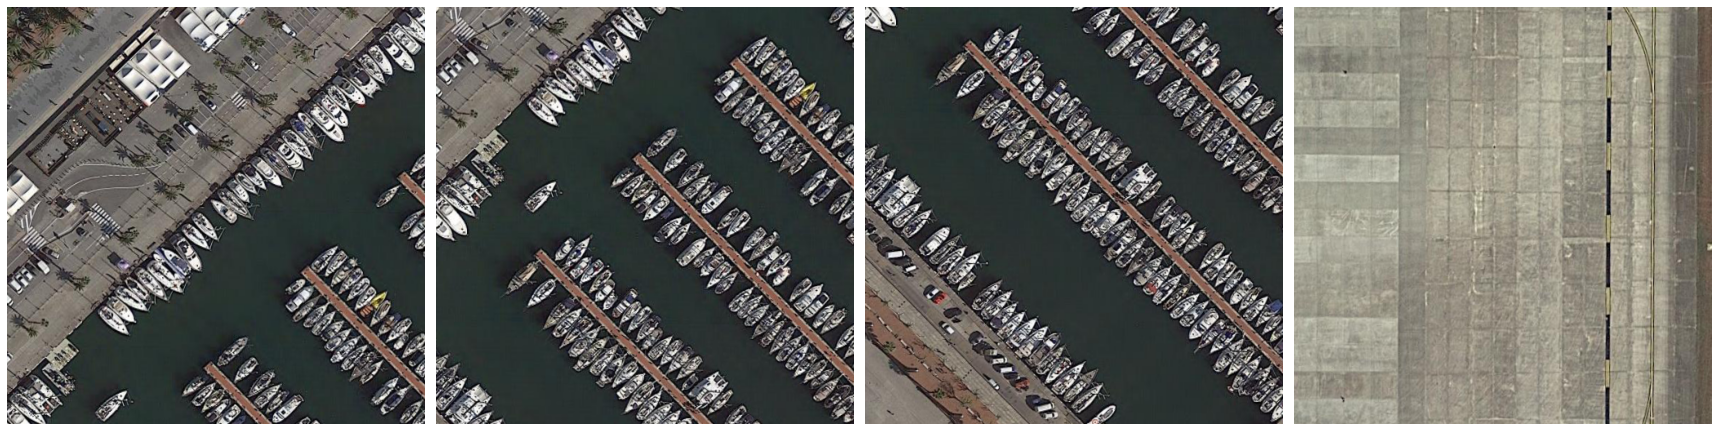

In [177]:
# Load sample dataset
train_dataset = Dataset(path='../assets/DOTA_sample_data/split')
train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

fig = plt.figure(figsize=(24, 8))
num_imgs = len(train_data_loader)
for idx, (img, obb, object_class) in enumerate(train_data_loader):
    img = img.to(device)
    print(img.shape)
    ax = fig.add_subplot(1, len(train_data_loader), idx + 1)
    ax.imshow(img.squeeze().permute(1, 2, 0).numpy())
    ax.set_axis_off()

plt.tight_layout()

Feeding image #1...
Feeding image #2...
Feeding image #3...
Feeding image #4...


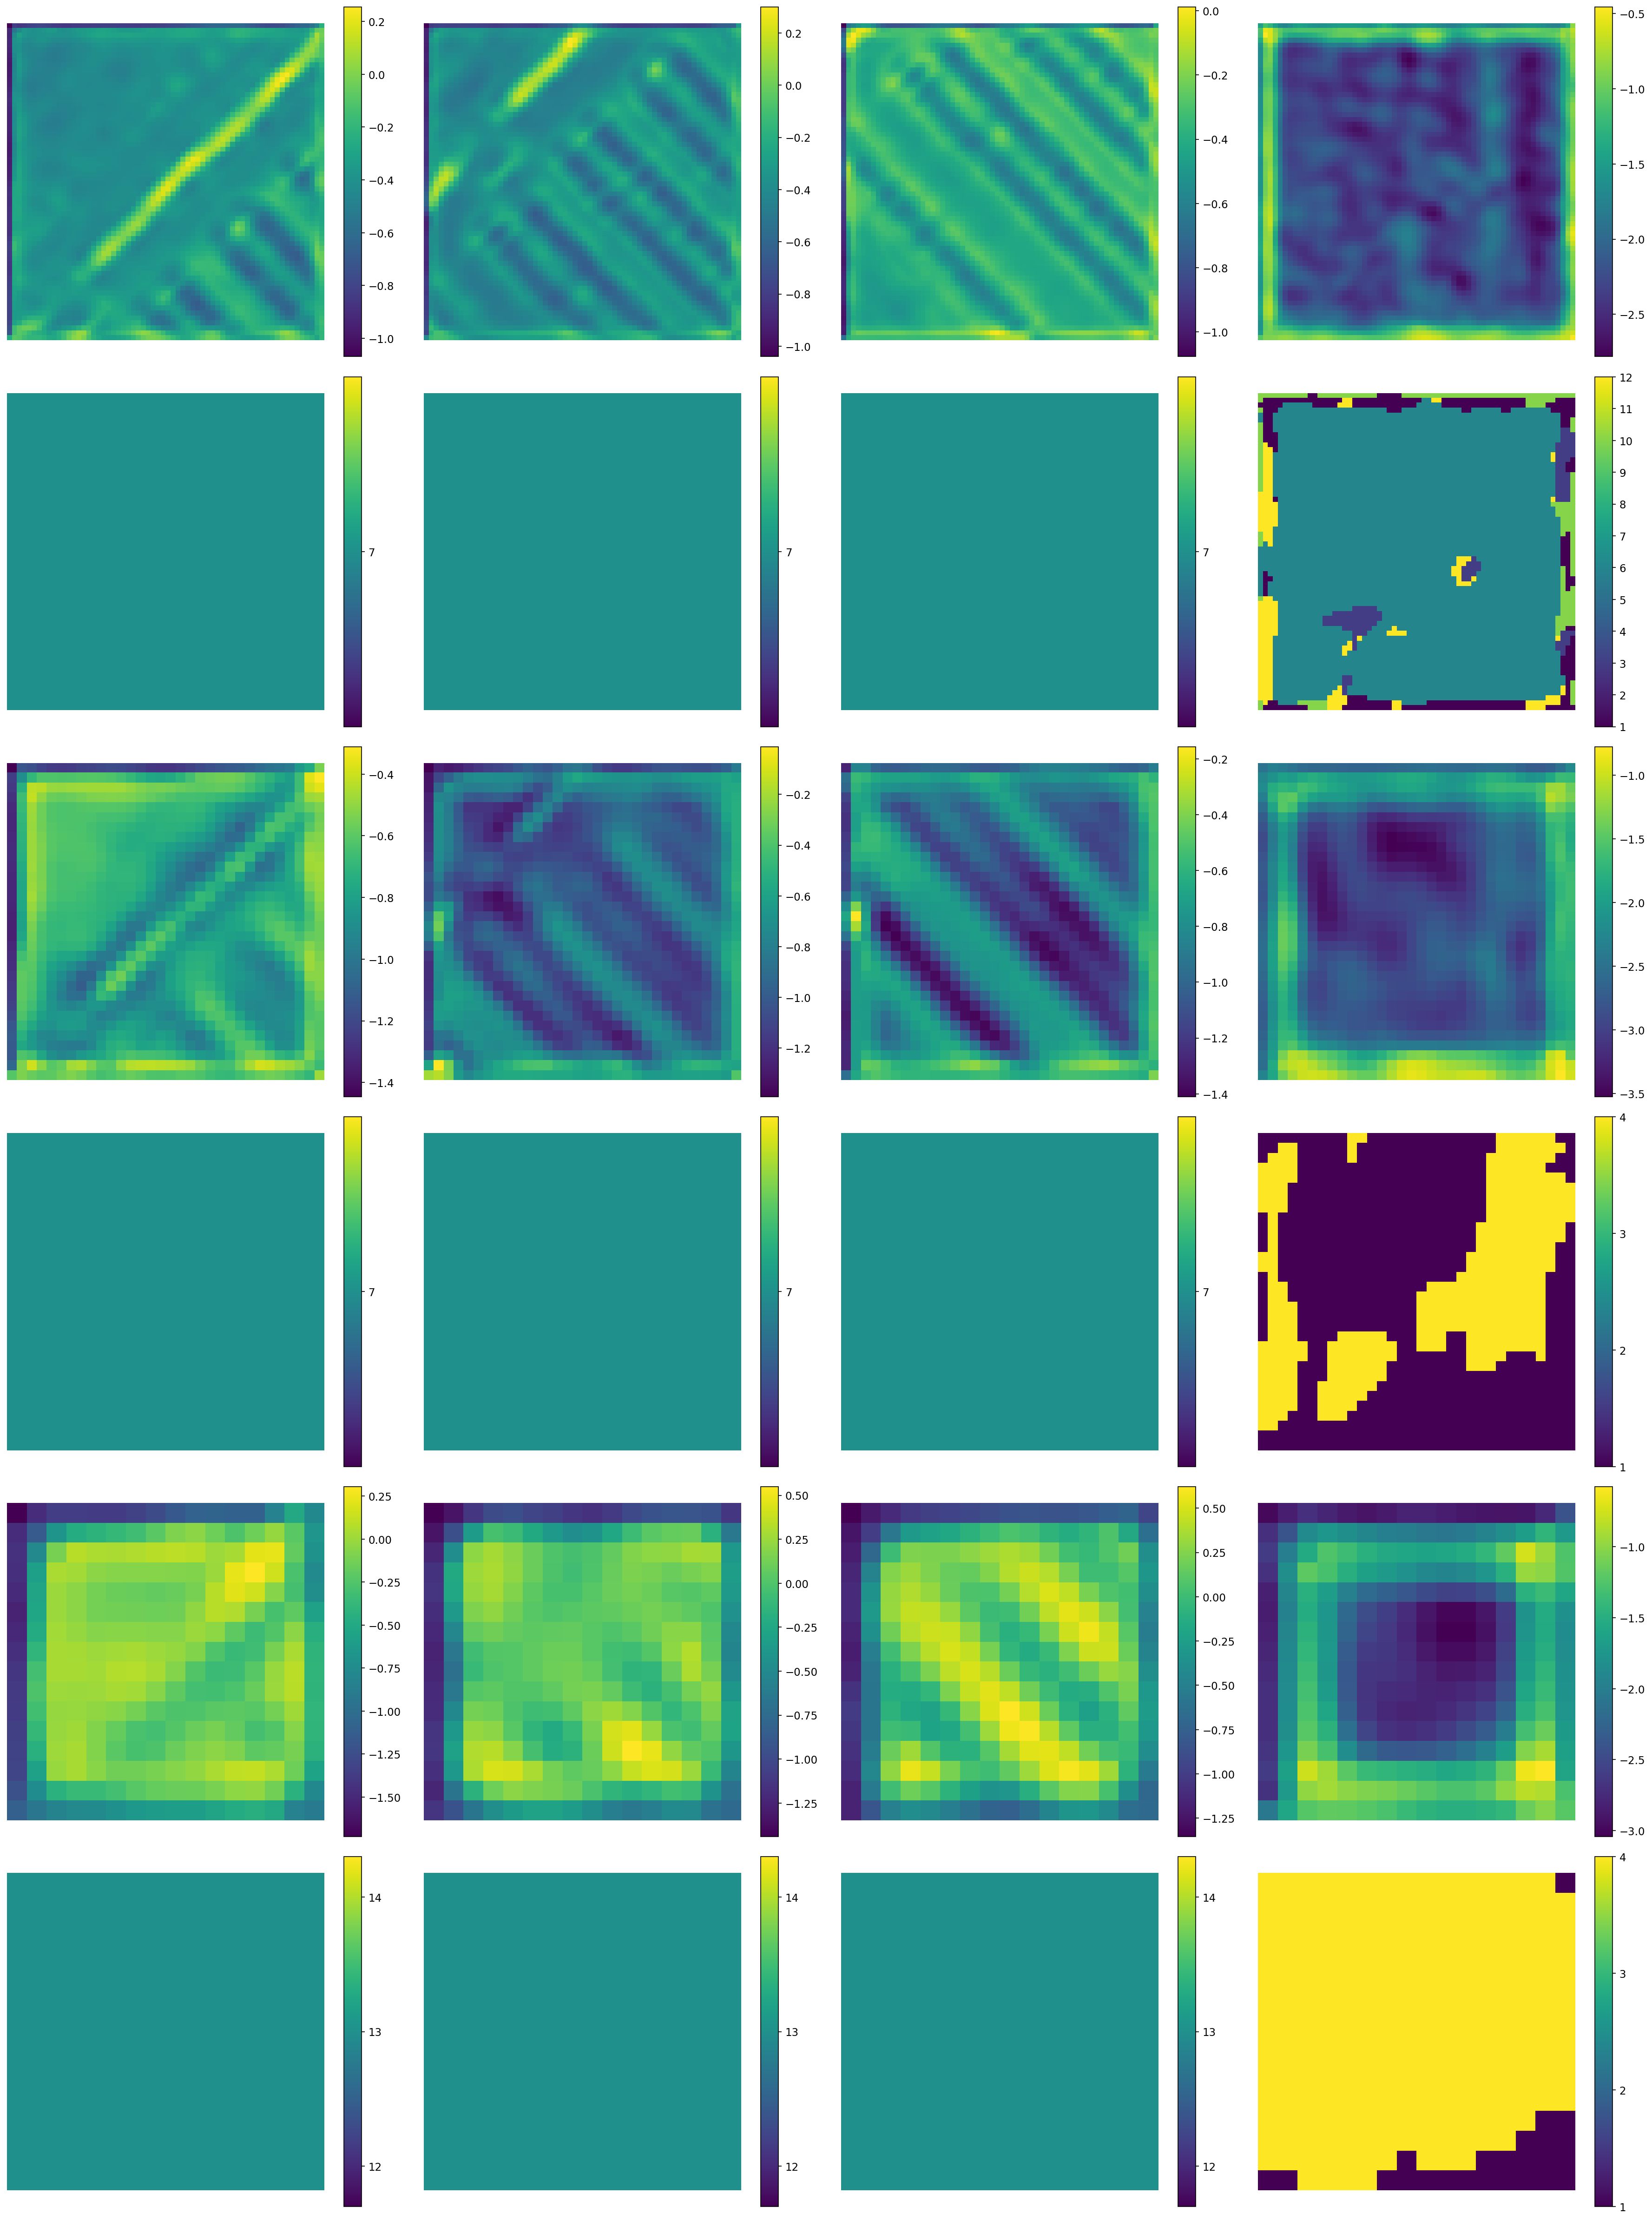

In [178]:
threshold = -0.5  # Classification threshold

# Get feature maps
fig = plt.figure(figsize=(24, 32), dpi=150)
for idx, (img, obb, object_class) in enumerate(train_data_loader):
    print(f'Feeding image #{idx+1}...')

    img = img.to(device)
    obb = obb.squeeze(dim=0)
    object_class = object_class.squeeze(dim=0)

    try:
        rep_points_init, rep_points_refine, classification = model(img)
    except:
        print('Error')
        continue

    num_lvls = len(classification.keys())
    for lvl_idx, lvl in enumerate(classification.keys()):
        # Get objectness, classification and RepPoints
        obj, cls = classification[lvl][0, 0], classification[lvl][0, 1:]

        # Confidence
        ax = fig.add_subplot(2 * num_lvls, len(train_data_loader), 2 * num_imgs * lvl_idx + idx + 1)
        obj_map = ax.imshow(obj.detach().numpy())
        ax.set_axis_off()
        plt.colorbar(obj_map)

        # Classification
        ax = fig.add_subplot(2 * num_lvls, len(train_data_loader), 2 * num_imgs * lvl_idx + idx + 1 + num_imgs)
        class_map = ax.imshow(torch.argmax(cls, dim=0).detach().numpy() + 1)
        ax.set_axis_off()
        plt.colorbar(class_map, ticks=range(0, 16))

        # TODO add localization

plt.tight_layout()